**Prerequisite**
1. Download LLama Model locally
  1. https://huggingface.co/TheBloke/Llama-2-13B-chat-GGUF/tree/main
2. Preload Sentence Transformer model (run the preload code below)

**Plan**

1. Use PDF document (e.g. a financial report)
2. Split using SentenceTransformer
3. Load to MongoDB
4. Search 
5. Add a prompt
6. Generate

In [12]:
import os
KAGGLE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '') != ''

In [13]:
# We will keep all global variables in an object to not pullute the global namespace.
class Object(object):
    pass

In [14]:
t = Object()

## Llama Config

In [15]:
# t.model_path = "../../data"
if KAGGLE:
    t.llm_path = "/kaggle/working/llama-2-13b-chat.Q6_K.gguf"
    t.layers = 50
else:    
#    t.model_path = "../../../data"
    t.model_path = "../../../data"
    t.llm_path = f"{t.model_path}/llama/llama-2-13b-chat.Q6_K.gguf"
    t.layers = 50

## Install Packages

In [16]:
if KAGGLE:
    !pip install langchain
    !pip install sentence-transformers
    !pip install "pymongo[srv]"
    !pip install typing-inspect==0.8.0 typing_extensions==4.5.0
    !pip install pypdf

In [17]:
if KAGGLE:
    !CMAKE_ARGS="-DLLAMA_CUBLAS=on" pip install llama-cpp-python==0.2.25 --force-reinstall --upgrade --no-cache-dir

In [18]:
if KAGGLE:
    !pip install -U numpy==1.24.1

## Pre-load Models

In [19]:
def preload():
    s = SentenceTransformersTokenTextSplitter()
    emb = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-cos-v1')

## Imports

In [20]:
from pymongo import MongoClient
import os
from llama_cpp import Llama
from langchain_community.llms import LlamaCpp
import torch
import umap
from tqdm import tqdm
# https://www.sbert.net/docs/pretrained_models.html#model-overview
# Sentence BERT, based on BERT
from sentence_transformers import SentenceTransformer
# https://api.python.langchain.com/en/latest/text_splitter/langchain.text_splitter.RecursiveCharacterTextSplitter.ht
# https://api.python.langchain.com/en/latest/text_splitter/langchain.text_splitter.SentenceTransformersTokenTextSplitter.html
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter, 
    SentenceTransformersTokenTextSplitter
)
from pypdf import PdfReader
import ctypes
import matplotlib.pyplot as plt
import pickle
import numpy as np

from llama_cpp import llama_log_set
# def my_log_callback(level, message, user_data):
#     pass
# log_callback = ctypes.CFUNCTYPE(None, ctypes.c_int, ctypes.c_char_p, ctypes.c_void_p)(my_log_callback)
# llama_log_set(log_callback, ctypes.c_void_p())

## MongoDB Config

In [21]:
if KAGGLE:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    t.uri = user_secrets.get_secret("MONGODB_URI")
else:
    t.uri = os.environ["MONGODB_URI"]
# Create a new client and connect to the server
t.client = MongoClient(t.uri)
# Send a ping to confirm a successful connection
try:
    t.client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [22]:
t.db = t.client.rag_llama
t.coll = t.db.mdb

In [23]:
if KAGGLE:
    !wget https://huggingface.co/TheBloke/Llama-2-13B-chat-GGUF/resolve/main/llama-2-13b-chat.Q6_K.gguf    
    preload()

## Load and Parse Documents

In [24]:
# t.reader = PdfReader("data/brk-2023-q3.pdf")
# t.reader = PdfReader("data/msft-2022.pdf")
if KAGGLE:
    t.reader = PdfReader(f"../input/mdb-pdf/{t.coll.name}-2022.pdf")
else:
    t.reader = PdfReader(f"data/{t.coll.name}-2022.pdf")
t.pages = [p.extract_text().strip() for p in t.reader.pages]

Pages are of various sizes. We need to split into chunks that fit into the model window, specifically, the BERT embedding 256-token sized window. 

So we'll join all pages, and use the SentenceTransformer splitter to split the doc into the chunks of the right size.

In [25]:
# print(t.pages[10])

In [26]:
t.ch_splitter =  RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1024,
    chunk_overlap=0
)
t.ch_chunks = t.ch_splitter.split_text("\n".join(t.pages))
len(t.ch_chunks)

573

In [27]:
t.token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=10, tokens_per_chunk=256)
t.token_chunks = []
for ch in t.ch_chunks:
    t.token_chunks.extend(t.token_splitter.split_text(ch))
len(t.token_chunks)

594

## Embedding Model

In [28]:
t.emb_model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-cos-v1')

In [29]:
len(t.emb_model.encode(t.token_chunks[21]).tolist())

768

## Upload documents

In [30]:
len(list(t.coll.find().limit(10)))

10

In [31]:
# t.docs = []
# for t.ch in t.token_chunks:
#     t.doc = {
#         "text": t.ch,
#         "embedding": t.emb_model.encode(t.ch).tolist()
#     }
#     t.docs.append(t.doc)
#
# _ = t.coll.insert_many(t.docs)

In [32]:
len(list(t.coll.find().limit(10)))

10

## Query Index

Index definition:

```
{
  "fields": [
    {
      "type": "vector",
      "path": "emb",
      "numDimensions": 768,
      "similarity": "dotProduct"
    }
  ]
}
```

In [33]:
t.query = "What was the total revenue?"

t.results = t.coll.aggregate([{
    "$vectorSearch": {
        "queryVector": t.emb_model.encode(t.query).tolist(),
        "path": "embedding",
        "numCandidates": 100,
        "limit": 8,
        "index": f"{t.coll.name}_vector_index"
    }}])

t.context = "\n\n".join([d['text'] for d in t.results])

In [34]:
print(t.context[0:1000])

operations ( in thousands of u. s. dollars, except share and per share data ) years ended january 31, 2023 2022 2021 revenue : subscription $ 1, 235, 122 $ 842, 047 $ 565, 349 services 48, 918 31, 735 25, 031

the following table presents the company ’ s revenues disaggregated by primary geographical markets, subscription product categories and services ( in thousands ) : years ended january 31, 2023 2022 2021 primary geographical markets : americas $ 781, 763 $ 527, 081 $ 361, 351 emea 361, 566 257, 846 177, 448 asia pacific 140, 711 88, 855 51, 581 total $ 1, 284, 040 $ 873, 782 $ 590, 380 subscription product categories and services : mongodb atlas - related $ 808, 263 $ 492, 287 $ 270, 805 other subscription 426, 859 349, 760 294, 544 services 48, 918 31, 735 25, 031 total $ 1, 284, 040 $ 873, 782 $ 590, 380 customers located in the united states accounted for 55 %, 54 % and 56 % of total revenue for the years ended january 31, 2023, 2022 and 2021, respectively. customers located i

## Load LLama

In [35]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

# https://python.langchain.com/docs/guides/local_llms
t.llm = LlamaCpp(
    model_path=t.llm_path,
    n_gpu_layers=t.layers,
    n_threads=10, 
    n_ctx=4096, 
    n_batch=512,
    verbose=False,
    f16_kv=True,
    callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
)

ggml_init_cublas: GGML_CUDA_FORCE_MMQ:   no
ggml_init_cublas: CUDA_USE_TENSOR_CORES: yes
ggml_init_cublas: found 1 CUDA devices:
  Device 0: NVIDIA GeForce RTX 3090, compute capability 8.6
llama_model_loader: loaded meta data with 19 key-value pairs and 363 tensors from ../../../data/llama/llama-2-13b-chat.Q6_K.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q6_K     [  5120, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  5120,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 13824,  5120,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight q6_K     [  5120, 13824,     1,     1 ]
llama_model_loader: - tensor    4:              blk.0.ffn_up.weight q6_K     [  5120, 13824,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_norm.weight f32      [  5120,     1,     1,     1 ]
llama_model_load

....................................................................................................
llama_new_context_with_model: n_ctx      = 4096
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_kv_cache_init: offloading v cache to GPU
llama_kv_cache_init: offloading k cache to GPU
llama_kv_cache_init: VRAM kv self = 3200.00 MiB
llama_new_context_with_model: kv self size  = 3200.00 MiB
llama_build_graph: non-view tensors processed: 924/924
llama_new_context_with_model: compute buffer total size = 361.07 MiB
llama_new_context_with_model: VRAM scratch buffer: 358.00 MiB
llama_new_context_with_model: total VRAM used: 13613.54 MiB (model: 10055.54 MiB, context: 3558.00 MiB)


## Query LLaMa

In [36]:
def ask(prompt, temp=0.8, top_p=0.95):
    out = t.llm.invoke(
        prompt, 
        max_tokens=512, 
        stop=["Q:"], 
        temperature=temp,
        top_p=top_p,
        top_k=10,
        repeat_penalty=1.2,
    )
    return out

Prompt Format:
```
<s>[INST] <<SYS>>
{{ system_prompt }}
<</SYS>>

{{ user_message }} [/INST]
```

### Query with RAG

In [37]:
def ask_with_context(question, context):
    full_prompt = (
    "<s>[INST]<<SYS>>\n"
    + "You are a helpful expert financial research assistant." 
    + "You answer questions about about information contained in a financial report."
    + "You will be given the user's question, and the relevant informaton from " 
    + "the financial report. Answer the question using only this information" 
    + "\n<</SYS>>\n\n"
    + "Information: {context}\n"
    + "Question: {question}\n"
    + "Answer:\n"
    + "[/INST]"
    )
    full_prompt = full_prompt.replace("{context}", context)
    full_prompt = full_prompt.replace("{question}", question)
    ask(full_prompt)

In [38]:
def find_context(question):
    results = t.coll.aggregate([{
    "$vectorSearch": {
        "queryVector": t.emb_model.encode(question).tolist(),
        "path": "embedding",
        "numCandidates": 200,
        "limit": 8,
        "index": f"{t.coll.name}_vector_index"
    }}])
    result_texts = [d['text'] for d in results]
    assert len(result_texts) > 0
    context = "\n\n".join(result_texts)
    return context

In [39]:
def ask_with_rag(question):
    context = find_context(question)
    ask_with_context(question, context)

In [40]:
%%time
ask_with_rag("What was the total revenue?")

  Based on the information provided, the total revenue for the years ended January 31, 2023, 2022, and 2021 was $1,284.0 million, $873.8 million, and $590.4 million, respectively.CPU times: user 2.89 s, sys: 602 ms, total: 3.49 s
Wall time: 3.57 s


In [41]:
%%time
ask_with_rag("What was the operating income or loss?")

  Based on the information provided, the operating income (loss) for the years ended January 31, 2023, 2022 and 2021 was as follows:

Year Ended January 31,
Operating Income (Loss)
-----------

2023 $(346,655)"

2022 $(289,364)"

2021 $(209,304)"CPU times: user 3.76 s, sys: 489 ms, total: 4.25 s
Wall time: 4.28 s


In [42]:
%%time
ask_with_rag("What was the operating income or loss in year 2022?")

  Based on the information provided in the financial report, the operating loss in Year 2022 was $(302,889).CPU times: user 1.75 s, sys: 372 ms, total: 2.12 s
Wall time: 2.22 s


In [43]:
%%time
ask_with_rag("Compare the total revenue between the years 2023 and 2022")

  Sure! Based on the information provided, the total revenue for the year ended January 31, 2023 was $1,284.0 million, while the total revenue for the year ended January 31, 2022 was $873.8 million. This represents a 47% increase from 2022 to 2023.CPU times: user 3.2 s, sys: 482 ms, total: 3.68 s
Wall time: 3.74 s


In [44]:
%%time
ask_with_rag("What time period does the report cover?")

  Based on the provided information, the report covers the fiscal year ended January 31, 2023.CPU times: user 1.34 s, sys: 313 ms, total: 1.65 s
Wall time: 1.75 s


In [45]:
%%time
ask_with_rag("Were there any changes to the executive team?")

  Based on the information provided in the Form 10-K, there were no changes to the executive team during the fiscal year ended January 31, 2023. The report lists the following individuals as the current principal executives and members of the board of directors:

* Dev Ittycheria, President, Chief Executive Officer, and Director
* Michael Gordon, Chief Operating Officer and Chief Financial Officer
* Thomas Bull, Chief Accounting Officer
* Tom Killalea, Director
* Archana Agrawal, Director
* Roelof Botha, Director
* Hope Cochran, Director
* Francisco D'Souza, Director
* Charles M. Hazard, Jr., Director

The report does not mention any changes to the executive team or board of directors during the fiscal year ended January 31, 2023.CPU times: user 5.67 s, sys: 563 ms, total: 6.24 s
Wall time: 6.2 s


### Query Embedded Knowledge

In [46]:
def ask_llm(question):
    prompt = (
        f"<s>[INST]<<SYS>>\n"
        + f"You are a helpful expert financial research assistant." 
        + f"\n<</SYS>>\n\n"
        + f"Question: {question}\n"
        + f"Answer:\n"
        + f"[/INST]"
    )
    ask(prompt)

In [47]:
%%time
ask_llm("What was the total revenue of MongoDB in the year ended January 31, 2023?")

  As a helpful expert financial research assistant, I can provide you with the total revenue of MongoDB for the year ended January 31, 2023.

According to the latest annual report filed by MongoDB with the Securities and Exchange Commission (SEC) on March 9, 2023, the company's total revenue for the year ended January 31, 2023 was $786.5 million.

Here is the breakdown of MongoDB's revenue by product and service:

* Subscription revenues: $643.9 million (82% of total revenue)
	+ Atlas (cloud database-as-a-service): $170.2 million (22% of subscription revenues)
	+ MongoDB Enterprise Advanced: $254.4 million (39% of subscription revenues)
	+ MongoDB Enterprise Standard: $138.3 million (21% of subscription revenues)
* Professional services and other revenues: $142.6 million (18% of total revenue)

Please note that these figures are based on the company's fiscal year ended January 31, 2023, and may not reflect more recent financial information or future results.CPU times: user 6.18 s, sys:

In [48]:
%%time
ask_llm("Were there any changes to the executive team at MongoDB in the year ended January 31, 2023?")

  Yes, there were some changes to the executive team at MongoDB during the year ended January 31, 2023. Here are the updates I found based on my research:

1. New CEO: In October 2022, MongoDB appointed Dev Ittycheria as its new Chief Executive Officer (CEO), effective November 1, 2022. He replaced former CEO and co-founder, Kevin Ryan, who stepped down from the role but remains on the company's board of directors.
2. New CFO: In January 2023, MongoDB appointed Michael Gordon as its new Chief Financial Officer (CFO). He joined the company from Zoom Video Communications, where he served as the Senior Vice President and Chief Financial Officer.
3. Other changes: Additionally, MongoDB's board of directors added two new members in 2022 - Dr. Min Tipton-King and Nicole Wong. Dr. Tipton-King is a seasoned technology executive with experience at companies like Google and Amazon Web Services (AWS), while Nicole Wong is a former Twitter executive who served as the company's Vice President of Le

## Visualize Embeddings

In [49]:
v = Object()

In [50]:
v.embeddings = list(t.coll.find({}, {"embedding": 1}))

In [51]:
v.emb_values = [e['embedding'] for e in v.embeddings]

In [52]:
def umap_embeddings(emb, umap_t):
    umap_emb = np.empty((len(emb),2))
    for i, e in enumerate(tqdm(emb)): 
        umap_emb[i] = umap_t.transform([e])
    return umap_emb

In [53]:
# Projections are slow, so we'll cache them
v.umap_all_emb_path = "umap_emb_all_docs.temp.pickle"

v.umap_transform = umap.UMAP(
    random_state=0, 
    transform_seed=0, 
    low_memory=False).fit(v.emb_values)

if os.path.exists(v.umap_all_emb_path):
    with open(v.umap_all_emb_path, "rb") as f:
        v.umap_all = pickle.load(f)
else:
    v.umap_all = umap_embeddings(v.emb_values, v.umap_transform)
    with open(v.umap_all_emb_path, "wb") as f:
        pickle.dump(v.umap_all, f)

/home/kalininalex/miniconda3/envs/py38/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [54]:
v.question = "What was the total revenue?"

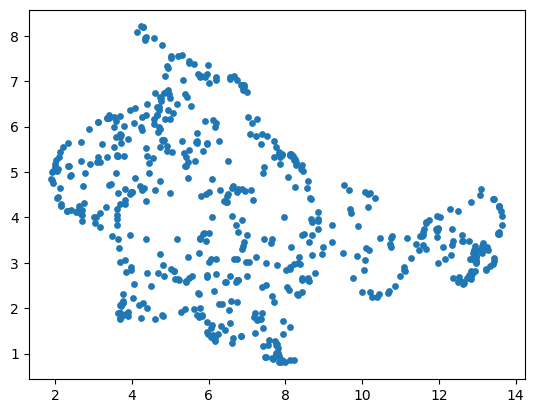

In [55]:
plt.figure()
plt.scatter(v.umap_all[:, 0], v.umap_all[:, 1], s=15)

In [56]:
v.results = t.coll.aggregate([{
    "$vectorSearch": {
        "queryVector": t.emb_model.encode(v.question).tolist(),
        "path": "embedding",
        "numCandidates": 200,
        "limit": 8,
        "index": f"{t.coll.name}_vector_index"
    }}]) 
v.results = list(v.results)

In [57]:
len(v.results)

8

In [58]:
v.umap_query = umap_embeddings([
    t.emb_model.encode(v.question)
], v.umap_transform)

100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


In [59]:
v.umap_query

array([[4.50944471, 3.11893868]])

In [60]:
v.umap_results = umap_embeddings(
    [d['embedding'] for d in v.results],
    v.umap_transform
)

100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


In [61]:
v.umap_results.shape

(8, 2)

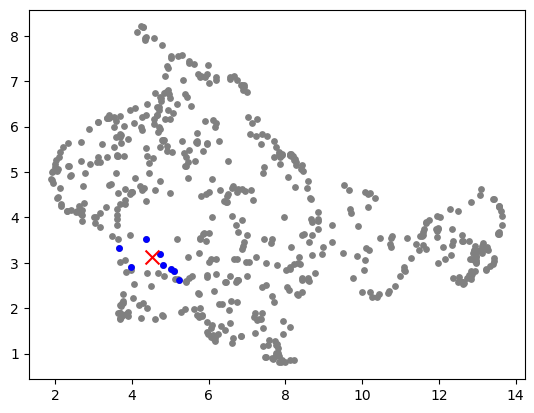

In [62]:
plt.figure()
plt.scatter(v.umap_all[:, 0], v.umap_all[:, 1], s=15, color="gray")
plt.scatter(v.umap_results[:, 0], v.umap_results[:, 1], s=15, color="blue")
plt.scatter(v.umap_query[:, 0], v.umap_query[:, 1], marker="x", s=100, color="r")

## Pitfalls

Vector search always returns results! These results may or may not be useful for the LLM to generate good answers, or stay within the topic.

In [63]:
%%time
ask_with_rag("Who won the last Super Bowl?")

  Based on the information provided in the financial report, I cannot answer your question about who won the last Super Bowl as it is not related to the company's financial performance or operations. The information provided in the financial report includes details about the company's revenue, income statement, balance sheet, and cash flow statements for the years ended January 31, 2023 and 2022, as well as certain notes to the consolidated financial statements. However, it does not include any information related to sports or the Super Bowl.CPU times: user 3.38 s, sys: 349 ms, total: 3.73 s
Wall time: 3.76 s


In [64]:
def query_and_plot_embeddings(coll, question, index_name, emb_model, umap_transform, umap_all):
    t = None
    v = None
    results = coll.aggregate([{
    "$vectorSearch": {
        "queryVector": emb_model.encode(question).tolist(),
        "path": "embedding",
        "numCandidates": 200,
        "limit": 8,
        "index": index_name
    }}]) 
    results = list(results)
    umap_query = umap_embeddings(
        [emb_model.encode(question)], 
        umap_transform)
    umap_results = umap_embeddings(
        [d['embedding'] for d in results],
        umap_transform)
    plt.figure()
    plt.scatter(umap_all[:, 0], umap_all[:, 1], s=15, color="gray")
    plt.scatter(umap_results[:, 0], umap_results[:, 1], s=15, color="blue")
    plt.scatter(umap_query[:, 0], umap_query[:, 1], marker="x", s=100, color="r")

100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


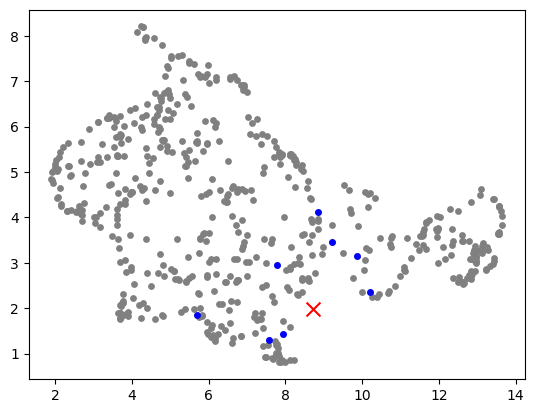

In [65]:
query_and_plot_embeddings(
    t.coll,
    "What team is Tom Brady playing for in 2024?",
    f"{t.coll.name}_vector_index",
    t.emb_model,
    v.umap_transform,
    v.umap_all
)

## LangChain

We'll use LangChain to tie this all together into a simple API.

In [66]:
# https://python.langchain.com/docs/integrations/vectorstores/mongodb_atlas

from langchain.chains import RetrievalQA
from langchain_community.vectorstores import MongoDBAtlasVectorSearch
from langchain_community.embeddings import HuggingFaceEmbeddings

In [67]:
l = Object()
l.llm = t.llm

In [68]:
l.lang_emb = HuggingFaceEmbeddings(model_name="multi-qa-mpnet-base-cos-v1")

Check that the embeddings model returns embeddings of the correct size of 768:

In [69]:
len(l.lang_emb.embed_documents(['This is a test document'])[0])

768

In [70]:
l.vector_search = MongoDBAtlasVectorSearch(
    t.coll, 
    l.lang_emb, 
    index_name="mdb_vector_index",
    embedding_key="embedding")

In [71]:
l.results = list(l.vector_search.max_marginal_relevance_search(
    query="What was the total revenue?",
    k = 8,
))

In [72]:
len(l.results)

8

### Make a Retriever Object

In [73]:
l.retriever = l.vector_search.as_retriever(search_kwargs={"k": 8})

### Make the end-to-end chain object

In [74]:
l.qa = RetrievalQA.from_chain_type(
    llm=l.llm, 
    retriever=l.retriever)

### Query LLM with LangChain

In [75]:
%%time
l.qa.invoke("What was the total revenue?")

 The total revenue for the year ended January 31, 2023, as reported in the financial statements provided, was $1,284,040.CPU times: user 2.27 s, sys: 638 ms, total: 2.9 s
Wall time: 2.82 s


{'query': 'What was the total revenue?',
 'result': ' The total revenue for the year ended January 31, 2023, as reported in the financial statements provided, was $1,284,040.'}

In [76]:
%%time
l.qa.invoke("What time period does the report cover?")

 The report covers the period ended January 31, 2023, which includes three years of financial statements.CPU times: user 1.4 s, sys: 268 ms, total: 1.66 s
Wall time: 1.77 s


{'query': 'What time period does the report cover?',
 'result': ' The report covers the period ended January 31, 2023, which includes three years of financial statements.'}